## LSTM Forecasting

Epoch 1/20


c:\Users\bollejayanthsriteja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0109
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.2713e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.1038e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.7776e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.7963e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.7211e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.4496e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.3275e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.0896e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.9768e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6724e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.6345e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6999e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.6081e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━

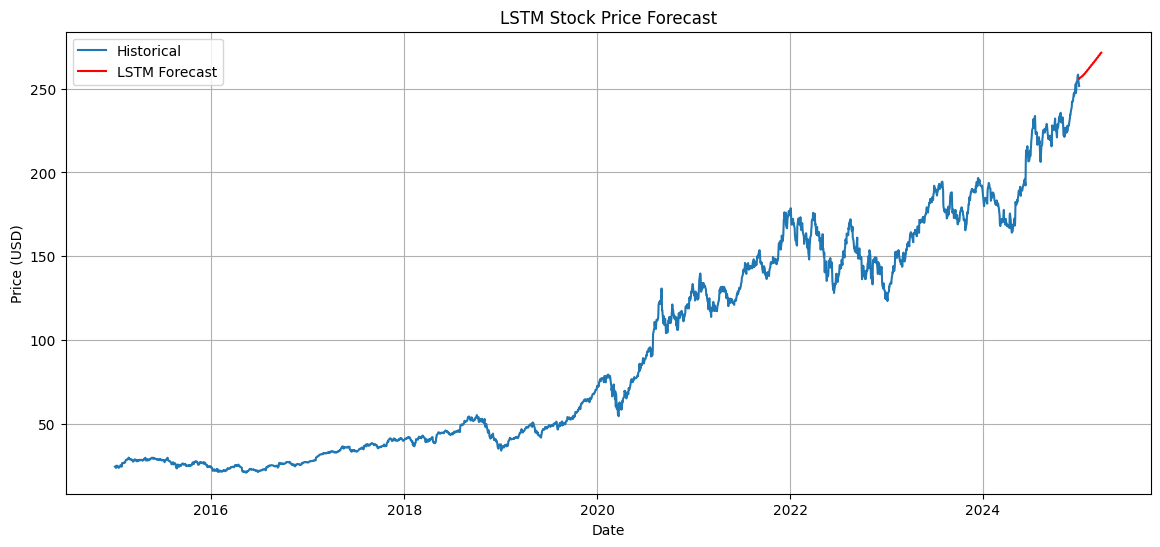

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df = pd.read_csv("AAPL_clean.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df[['Close']].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=20, batch_size=32)

last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(60):
    seq_input = last_sequence.reshape(1, seq_length, 1)
    pred = model.predict(seq_input, verbose=0)
    predictions.append(pred[0,0])
    last_sequence = np.append(last_sequence[1:], pred).reshape(seq_length, 1)

predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')

os.makedirs("Models", exist_ok=True)
lstm_output = pd.DataFrame({'Date': future_dates, 'Forecast': predicted_prices.flatten()})
lstm_output.to_csv("Models/future_lstm.csv", index=False)

print("LSTM predictions saved to 'Models/future_lstm.csv'")

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Historical')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast', color='red')
plt.legend()
plt.title("LSTM Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()